# Programming Exercise 8: Anomaly Detection and Recommender Systems
> In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies.

## 1. Anomaly Detection
> In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server.

In [368]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [369]:
mat = scipy.io.loadmat('data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

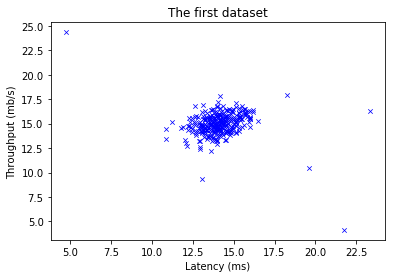

In [370]:
ax = sns.scatterplot(mat['X'][:,0], mat['X'][:,1], marker='x', color='b', s=20)
ax.set(xlabel='Latency (ms)', ylabel='Throughput (mb/s)', title='The first dataset');

### 1.1 Gaussian Distribution

> To perform anomaly detection, you will first need to fit a model to the data’s distribution.

The Gaussian distribution is given by: 

$$p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} = \frac{1}{\sqrt{(2\pi^k)det\Sigma}}e^{-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)}$$

where $\mu$ is the mean and $\sigma^2$ controls the variance; $\Sigma$ is the covariance matrix and $k$ is the dimension of the space where $x$ takes values.

### 1.2 Estimating Parameters for a Gaussian

Mean: $\mu_i = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}$

Variance: $\sigma_i^2 = \frac{1}{m}\sum_{j=1}^m(x_i^{(j)}-\mu_i)^2$

In [371]:
def estimate_gaussian(X):
    mean = np.mean(X, axis=0)
    var = np.var(X, axis=0)
    return mean, var

In [372]:
from scipy.stats import multivariate_normal
def multivariate_gaussian(X, mu, sigma):
    p = multivariate_normal.pdf(X, mu, np.diag(sigma))
    return p

In [373]:
mu, sigma2 = estimate_gaussian(mat['X'])
mu, sigma2

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [374]:
p = multivariate_gaussian(mat['X'], mu, sigma2)

In [375]:
def visualize_fit(X, mu, sigma2):
    x, y = np.mgrid[0:35.5:0.5, 0:35.5:0.5]
    pos = np.dstack((x, y))
    z = multivariate_gaussian(pos, mu, sigma2)
    z = z.reshape(x.shape)
    ax = sns.scatterplot(X[:,0], X[:,1], marker='x', color='b', s=20)
    ax.contour(x, y, z, levels=10.0**(np.arange(-20,0,3)))
    ax.set(xlabel='Latency (ms)', ylabel='Throughput (mb/s)', title='Visualizing Gaussian Fit');
    ax.set_xlim(0,30)
    ax.set_ylim(0,30)
    return ax

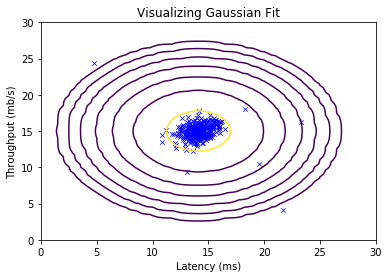

In [376]:
visualize_fit(mat['X'], mu, sigma2)

### 1.3 Selecting the threshold $\epsilon$

The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the $F1 score$ on a cross validation set.

$$F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}$$

$$prec = \frac{tp}{tp+fp}$$

$$rec = \frac{tp}{tp+fn}$$

* tp: true positive; label says it's true and our algorithm too
* fp: false positive; label says it's not true and our algorithm says it's true
* fn: false negative; label says it's true and our algorithm says it's not true

In [377]:
def select_threshold(yval, pval):
    best_f1 = 0
    best_epsilon = 0
    step = (np.max(pval) - np.min(pval))/1000
    for epsilon in np.arange(np.min(pval), np.max(pval), step):
        y_pred = pval < epsilon
        tp = np.sum(np.logical_and(yval == 1, y_pred == 1))
        fp = np.sum(np.logical_and(yval == 0, y_pred == 1))
        fn = np.sum(np.logical_and(yval == 1, y_pred == 0))
        
        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        
        f1 = (2*precision*recall)/(precision+recall)
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    return best_epsilon, best_f1

In [378]:
pval = multivariate_gaussian(mat['Xval'], mu, sigma2)

In [379]:
epsilon, f1 = select_threshold(mat['yval'].ravel(), pval)

/Users/suellen/workspace/github/machine-learning-andrew-ng/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [380]:
print('Best epsilon found using cross-validation:', epsilon)
print('Best F1 on Cross Validation Set:', f1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

Best epsilon found using cross-validation: 8.990852779269493e-05
Best F1 on Cross Validation Set: 0.8750000000000001
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


In [381]:
outliers = np.argwhere(p < epsilon)
outliers = outliers.T[0]

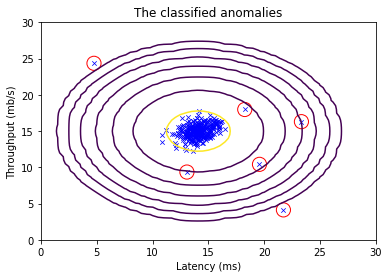

In [382]:
ax = visualize_fit(mat['X'], mu, sigma2)
ax.scatter(x=mat['X'][outliers,0], y=mat['X'][outliers,1], color='r', facecolors='none', s=200)
ax.set(title='The classified anomalies');

### 1.4 High Dimensional Dataset

In [363]:
mat = scipy.io.loadmat('data/ex8data2.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [366]:
mu, sigma2 = estimate_gaussian(mat['X'])
p = multivariate_gaussian(mat['X'], mu, sigma2)
pval = multivariate_gaussian(mat['Xval'], mu, sigma2)
epsilon, f1 = select_threshold(mat['yval'].ravel(), pval)

/Users/suellen/workspace/github/machine-learning-andrew-ng/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [367]:
print('Best epsilon found using cross-validation:', epsilon)
print('Best F1 on Cross Validation Set:', f1)
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)')
print('# Outliers found: ', sum(p < epsilon))

Best epsilon found using cross-validation: 1.3772288907613604e-18
Best F1 on Cross Validation Set: 0.6153846153846154
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found:  117


## 2. Recommender Systems

> In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of $1$ to $5$. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. 

### 2.1 Movie Ratings Dataset

* Matrix $Y$ (num_movies x num_users): ratings $y^{(i,j)}$ (from 1 to 5)
* Matrix $R$: binary where $R(i,j)=1$ if user $j$ gave a rating to movie $i$, and $R(i,j)=0$ otherwise.
* Matrix $X$: each row corresponds to the feature vector $x^{(i)}$ for the i-th movie.
* Matrix $Theta$: each row corresponds to one parameter vector $\theta^{(j)}$ for the j-th user.

In [412]:
mat = scipy.io.loadmat('data/ex8_movies.mat')
Y = mat['Y']
R = mat['R']

In [413]:
mat2 = scipy.io.loadmat('data/ex8_movieParams.mat')
X = mat2['X']
Theta = mat2['Theta']
num_users = mat2['num_users']
num_movies = mat2['num_movies']
num_features = mat2['num_features']

In [426]:
f'Average rating for movie 1 (Toy Story): {np.mean(Y[0, R[0,:]==1])} / 5'

'Average rating for movie 1 (Toy Story): 3.8783185840707963 / 5'

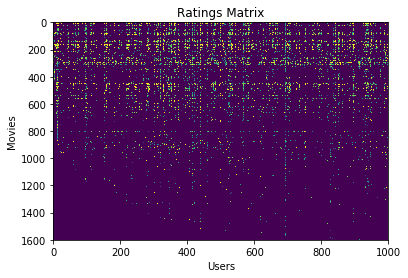

In [444]:
plt.imshow(Y, extent=[0,1000,1600,0], aspect='auto')
plt.title('Ratings Matrix');
plt.xlabel('Users');
plt.ylabel('Movies');

### 2.2 Collaborative Filtering Learning Algorithm

> The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)} , ..., x^{(n_m)}$ and $\theta^{(1)},...,\theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

#### 2.2.1 Collaborative filtering cost function (without regularization)

$$ J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) = \frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})^2$$

In [446]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2
    return J

In [447]:
#reduce dataset to test
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [450]:
J = cofi_cost_func(np.hstack((X.ravel(order='F'), Theta.ravel(order='F'))),
                   Y, R, num_users, num_movies, num_features, 0)
print('Cost at loaded parameters: ', J)
print('\t(this value should be about 22.22)')

Cost at loaded parameters:  22.224603725685675
	(this value should be about 22.22)


#### 2.2.2 Collaborative filtering gradient (without regularization)

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})\theta_k^{(j)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)} $$

In [460]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2
    
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:])
        
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:])
        
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad

##### Checking Gradients (without regularization)

In [461]:
def compute_numerical_gradient(theta, Y, R, num_users, num_movies, num_features, lambda_r):
    e = 0.0001
    num_grad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    for p in range(len(theta)):
        perturb[p] = e
        loss1,_ = cofi_cost_func(theta-perturb, Y, R, num_users, num_movies, num_features, lambda_r)
        loss2,_ = cofi_cost_func(theta+perturb, Y, R, num_users, num_movies, num_features, lambda_r)
        num_grad[p] = (loss2-loss1)/(2*e)
        perturb[p] = 0
    return num_grad

In [462]:
def check_cost_function(lambda_r=0):
    X_t = np.random.uniform(0,1,(4,3))
    Theta_t = np.random.uniform(0,1,(5,3))
    
    Y = X_t.dot(Theta_t.T)
    Y[np.random.uniform(0,1,Y.shape)>0.5] = 0
    R = np.zeros(Y.shape)
    R[Y!=0] = 1
    
    X = np.random.normal(size=X_t.shape)
    Theta = np.random.normal(size=Theta_t.shape)
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    params = np.hstack((X.ravel(order='F'), Theta.ravel(order='F')))
    
    cost, grad = cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r)
    num_grad = compute_numerical_gradient(params, Y, R, num_users, num_movies, num_features, lambda_r)
    
    print('The columns should be very similar...')
    for i, j in zip(num_grad, grad):
        print(i,j)
        
    diff = np.linalg.norm(num_grad-grad)/np.linalg.norm(num_grad+grad)
    print('''If your cost function implementation is correct, then the relative difference will 
             be small (less than 1e-9). Relative Difference:''', diff)

In [463]:
check_cost_function()

The columns should be very similar...
4.534710280985621 4.534710280987838
-5.15389514749387 -5.153895147477099
2.0676030457877914 2.0676030457883914
1.710344108012407 1.7103441080090966
-5.463542401216159 -5.463542401214781
6.668686071904517 6.668686071916491
-4.84571787458421 -4.845717874595353
-2.2667239972840036 -2.266723997296472
-1.6398196269129528 -1.6398196269149445
2.214904425379416 2.2149044253903263
-0.7788080677428866 -0.778808067722867
-0.4352805963669937 -0.4352805963653944
-0.736120681548158 -0.7361206815563007
6.822943656654701 6.822943656666209
-9.66455117627163 -9.664551176268647
1.8165669567338227 1.8165669567259517
1.9700208824424692 1.9700208824342398
-1.5015643731253192 -1.5015643731360209
-1.996882072887729 -1.996882072899521
16.464228418620053 16.464228418620817
-1.612611128756214 -1.6126111287545721
3.1563994247107985 3.156399424700015
-0.25795459185573577 -0.2579545918661169
-2.518921166281274 -2.5189211662717823
3.1874141775567466 3.1874141775485088
-0.8614888

#### 2.2.3 Regularized cost function

$$ J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) = \frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})^2 + 
\Big(\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n}(\theta_k^{(j)})^2 \Big) + \Big(\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}(x_k^{(i)})^2 \Big)$$

In [464]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2 + ((lambda_r/2)*np.sum(np.sum(Theta**2))) + ((lambda_r/2)*np.sum(np.sum(X**2)))
    
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:])
        
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:])
        
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad

In [466]:
J, _ = cofi_cost_func(np.hstack((X.ravel(order='F'), Theta.ravel(order='F'))),
                   Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters (lambda = 1.5):', J)
print('\t(this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.34405624427422
	(this value should be about 31.34)


#### 2.2.4 Regularized gradient

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})\theta_k^{(j)} + \lambda x_k^{(i)}$$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)} + \lambda \theta_k^{(j)}$$



In [467]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2 + ((lambda_r/2)*np.sum(np.sum(Theta**2))) + ((lambda_r/2)*np.sum(np.sum(X**2)))
    
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:]) + (lambda_r * X[i,:])
        
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:]) + (lambda_r * Theta[j,:])
        
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad

In [468]:
check_cost_function(1.5)

The columns should be very similar...
-1.4524081545630452 -1.4524081545243543
-3.9894665798811957 -3.989466579935604
-3.8493748256485105 -3.8493748256961533
5.89234950275852 5.892349502838272
24.588504805649336 24.588504805584734
-3.411648310773785 -3.4116483107856017
17.299202177056827 17.299202177077966
-4.048848950901629 -4.048848950914966
3.8448012167435763 3.844801216718646
-10.625284772700638 -10.625284772687126
-0.03590040478229639 -0.035900404744119374
-8.403440972699627 -8.403440972745564
-7.542464301408813 -7.542464301432494
11.234351626256966 11.234351626229781
5.043464659522101 5.043464659512603
-7.5578869003578575 -7.557886900429807
1.61794649038427 1.617946490351315
-8.297124341751783 -8.297124341805954
-24.996637089458318 -24.99663708937739
-15.263339168143375 -15.263339168118492
1.4649656390020027 1.4649656390125518
-0.5995500631428285 -0.5995500631858357
-11.662631582041172 -11.662631582031164
3.429218116295374 3.429218116256577
-1.092262164874569 -1.0922621648905948
1

### 2.3 Learning movie recommendations

In [480]:
with open('data/movie_ids.txt', encoding='latin-1') as f:
    content = f.readlines()
    
movie_list = [' '.join(line.split()[1:]) for line in content]

In [482]:
len(movie_list)

1682

In [483]:
movie_list[:5]

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)']

In [490]:
my_ratings = np.zeros((1682, 1))
my_ratings[0] = 4
my_ratings[10] = 4
my_ratings[21] = 5
my_ratings[70] = 5
my_ratings[97] = 2
my_ratings[98] = 5
my_ratings[150] = 4
my_ratings[154] = 4
my_ratings[175] = 3
my_ratings[312] = 5

In [491]:
for i,r in enumerate(my_ratings):
    if r>0:
        print('Rated {0} for {1}'.format(int(r[0]), movie_list[i]))

Rated 4 for Toy Story (1995)
Rated 4 for Seven (Se7en) (1995)
Rated 5 for Braveheart (1995)
Rated 5 for Lion King, The (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 5 for Snow White and the Seven Dwarfs (1937)
Rated 4 for Willy Wonka and the Chocolate Factory (1971)
Rated 4 for Dirty Dancing (1987)
Rated 3 for Aliens (1986)
Rated 5 for Titanic (1997)


In [493]:
mat = scipy.io.loadmat('data/ex8_movies.mat')
Y = np.hstack((my_ratings,mat['Y']))
R = np.hstack((my_ratings!=0,mat['R']))

In [514]:
Y.shape

(1682, 944)

#### Training Collaborative Filtering

In [550]:
def normalize_ratings(Y, R):
    Y_mean = np.zeros((Y.shape[0], 1))
    Y_norm = np.zeros(Y.shape)
    for i in range(Y.shape[0]):
        idx = np.argwhere(R[i,:]==1).T[0]
        Y_mean[i] = np.mean(Y[i,idx], axis=0)
        Y_norm[i,idx] = np.subtract(Y[i,idx], Y_mean[i])
    return Y_norm, Y_mean

In [551]:
Y_norm, Y_mean = normalize_ratings(Y, R)

In [552]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

In [553]:
X = np.random.normal(size=(num_movies, num_features))
Theta = np.random.normal(size=(num_users, num_features))
initial_params = np.hstack((X.ravel(order='F'), Theta.ravel(order='F')))

In [554]:
import scipy.optimize as opt
lambda_r = 10
opt_results = opt.minimize(cofi_cost_func, initial_params, args=(Y, R, num_users, num_movies, num_features, lambda_r),
                           method='L-BFGS-B', jac=True, options={'maxiter':100})
theta = opt_results['x']

In [555]:
X = np.reshape(theta[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
Theta = np.reshape(theta[num_movies*num_features:], newshape=(num_users, num_features), order='F')    

#### Recommendation

In [556]:
p = X.dot(Theta.T)
my_predictions = p[:,0] + Y_mean.T[0]

In [569]:
sort_idxs = np.argsort(my_predictions)[::-1]
print('Top recommendations for you:')
for i in range(10):
    j = sort_idxs[i]
    print('Predicting rating {0} for movie {1}'.format(my_predictions[j], movie_list[j]))

Top recommendations for you:
Predicting rating 8.368993278584279 for movie Titanic (1997)
Predicting rating 8.288858532809607 for movie Schindler's List (1993)
Predicting rating 8.234374133130322 for movie Shawshank Redemption, The (1994)
Predicting rating 8.044420702919398 for movie Star Wars (1977)
Predicting rating 7.96560643547238 for movie Good Will Hunting (1997)
Predicting rating 7.962937588003024 for movie Raiders of the Lost Ark (1981)
Predicting rating 7.941203005532051 for movie Braveheart (1995)
Predicting rating 7.804394669167708 for movie Casablanca (1942)
Predicting rating 7.771370067735939 for movie Usual Suspects, The (1995)
Predicting rating 7.727566323174965 for movie Empire Strikes Back, The (1980)


In [571]:
print('Original ratings provided:')
for i,r in enumerate(my_ratings):
    if r>0:
        print('Rated {0} for {1}'.format(int(r[0]), movie_list[i]))

Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 4 for Seven (Se7en) (1995)
Rated 5 for Braveheart (1995)
Rated 5 for Lion King, The (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 5 for Snow White and the Seven Dwarfs (1937)
Rated 4 for Willy Wonka and the Chocolate Factory (1971)
Rated 4 for Dirty Dancing (1987)
Rated 3 for Aliens (1986)
Rated 5 for Titanic (1997)
